In [1]:
using Flux
using Plots

In [2]:
function loss_mse(model, features, labels)
    y_hat = model(features)
    return Flux.mse(y_hat, labels)
end

loss_mse (generic function with 1 method)

In [3]:
function loss_lasso(model, features, labels; lambda=0.01)
    y_hat = model(features)
    mse_loss = Flux.mse(y_hat, labels)
    l1_penalty = lambda * sum(abs.(model.weight))
    return mse_loss + l1_penalty
end

loss_lasso (generic function with 1 method)

In [4]:
function loss_ridge(model, features, labels; lambda=0.01)
    y_hat = model(features)
    mse_loss = Flux.mse(y_hat, labels)
    l2_penalty = lambda * sum(model.weight .^ 2)
    return mse_loss + l2_penalty
end

loss_ridge (generic function with 1 method)

In [5]:
function loss_elastic_net(model, features, labels; lambda1=0.01, lambda2=0.01)
    y_hat = model(features)
    mse_loss = Flux.mse(y_hat, labels)
    l1_penalty = lambda1 * sum(abs.(model.weight))
    l2_penalty = lambda2 * sum(model.weight .^ 2)
    return mse_loss + l1_penalty + l2_penalty
end

loss_elastic_net (generic function with 1 method)

In [6]:
function train_model!(loss, model, features, labels; learning_rate=0.01)
    dLdm, _, _ = gradient(loss, model, features, labels)
    @. model.weight = model.weight - learning_rate * dLdm.weight
    @. model.bias = model.bias - learning_rate * dLdm.bias
end

function train_model!(loss, model, data; learning_rate=0.01)
    Flux.train!(loss, model, data, Descent(learning_rate))
end

train_model! (generic function with 2 methods)

In [7]:
function train_until_converged!(loss, model, data; max_epochs=10000, tolerance=1e-4, learning_rate=0.01)
    x = hcat([d[1] for d in data]...)
    y = hcat([d[2] for d in data]...)
    loss_prev = Inf
    for epoch in 1:max_epochs
        train_model!(loss, model, data; learning_rate=learning_rate)
        current_loss = loss(model, x, y)

        if loss_prev == Inf
            loss_prev = current_loss
            continue
        end

        if current_loss < 1 && abs(loss_prev - current_loss) < tolerance
            println("Converged at epoch $epoch with loss $current_loss")
            break
        end
        loss_prev = current_loss
    end
end

train_until_converged! (generic function with 1 method)

In [8]:
f(x) = 2 + 3x + 5x^2 - 3x^3
data = []
for i in -3:0.1f0:3
    x = i + rand(Float32)
    xi = [x, x^2, x^3]
    yi = f(i) + rand(Float32)
    push!(data, (xi, yi))
end
x = hcat([d[1] for d in data]...)
y = hcat([d[2] for d in data]...)

1×61 Matrix{Float32}:
 119.151  108.908  99.3015  89.8264  80.9924  …  -15.4252  -19.7405  -24.8558

In [9]:
degree = 3  # 多項式の次数

loss = (model, x, y) -> loss_mse(model, x, y)
model = Flux.Dense(degree => 1)

train_until_converged!(loss, model, data; learning_rate=0.0003)
predicted_values = model(x)

1×61 Matrix{Float32}:
 115.879  125.679  69.6232  71.945  89.2473  …  -14.8464  -17.1716  -18.4307

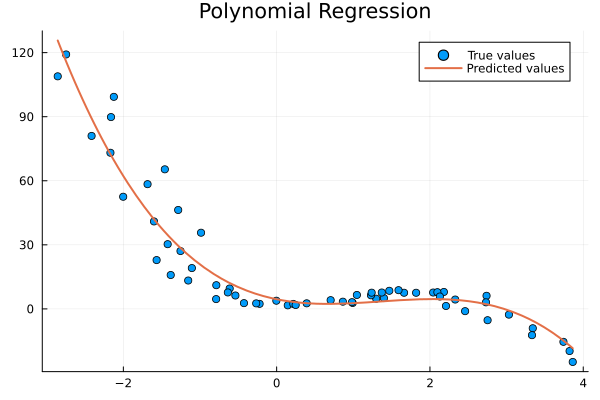

In [10]:
plot(x[1,:], vec(y), seriestype=:scatter, label="True values", title="Polynomial Regression")
plot!((x) -> model.bias[1] + model.weight[3] * x^3 + model.weight[2] * x^2 + model.weight[1] * x, label="Predicted values", lw=2)

In [11]:
Flux.params(model)

Params([Float32[-7.2866645 7.220579 -1.7789204], Float32[4.5149546]])